# Covid-19 predictor using posteroanterior (PA) chest X-ray images
> An attempt to detect covid-19 from x-ray images of suspected individuals
- toc: false
- branch: master
- badges: true
- show_image: true
- image: images/confusion_matrix.png
- comments: true
- author: Prateek Karkare
- categories: [deeplearning, fastai, jupyter]

The X-ray dataset is taken from - https://github.com/ieee8023/covid-chestxray-dataset.

I have been running this code on Google Colab environment using a GPU as a hardware accelerator. Since the notebook is using Resnet50 for transfer learning you will need a machine with an NVIDIA GPU otherwise the training might take ages

The folder structure I am using here to store the images is -
<br>
Covid/
<br>
----| covid_positive
<br>
----| covid_negative
<br>
----| metadata.csv (This can be downloaded from the open source database)

Fast AI makes it extremely simple if you make a folder for each of your class and put all the respective images in that folder

> Important: Pay attention! This notebook by no means is an accurate model to predict covid-19 or make any kind of diagnosis whatsoever. This is an ongoing experiment being done using opensource databases just as a POC. The model is not suitable for deployment.*

In [0]:
from fastai.vision import *
from fastai.widgets import *
import pandas as pd

Mount Google Drive with path to folders containing images. You need to change this path to point to the folder which contains the x-ray images


In [0]:
drive_path = 'drive/My Drive/FastAI/Covid/'

In [0]:
df = pd.read_csv(drive_path+'metadata.csv')

In [0]:
covid_positive = df['finding'] == 'COVID-19'

In [0]:
xrays = df['modality'] == 'X-ray'
CT = df['modality'] == 'CT'
PA = df['view'] == 'PA'
AP = df['view'] == 'AP'

I have cloned the image repository to my local machine. Since I am running this notebook on Colab I have to run a script on my local machine to upload the covid_postive and covid_negative images to my google drive.

PA_covid and PA_non_covid gives me the list of file names which are then uploaded to google drive

In [0]:
PA_covid = df[covid_positive & PA ]
PA_non_covid = df[PA & ~covid_positive]

In [0]:
#List files belonging to both the classes
covid_images = [files for files in PA_covid['filename']]
non_covid_images = [files for files in PA_non_covid['filename']]

In [0]:
path = Path(drive_path)

In [0]:
classes = ['covid_positive', 'covid_negative']

In [10]:
#sanity check images
for c in classes:
  verify_images(path/c)

In [0]:
#Split data into train and validation sets
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", test='test', valid_pct=0.20,
        ds_tfms=get_transforms(), bs=8, size=512, num_workers=4).normalize(imagenet_stats)

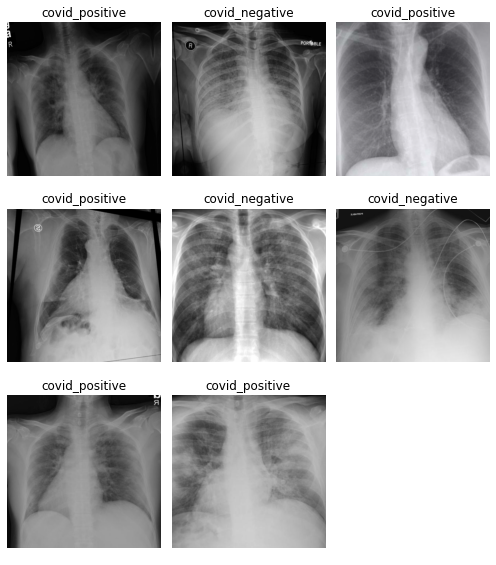

In [12]:
#View data
data.show_batch(rows=3, figsize=(7,8))

In [13]:
#hide
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['covid_negative', 'covid_positive'], 2, 149, 49, 30)

## Training
We are using a Resnet50 for transfer learning. Using fit one cycle for a few epochs and then using fastai's lrfinder to find an optimal range for our learning rate.

We use precision and recall to measure the incidents of false positives and false negatives.

In [0]:
precision=Precision()
recall=Recall()
AUC=AUROC()

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=(accuracy, precision, recall, AUC))

In [51]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.872759,0.330885,0.897959,0.900000,0.857143,0.952381,00:15


In [0]:
learn.save('stage-1')

Use lr_find() to choose learning rate

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


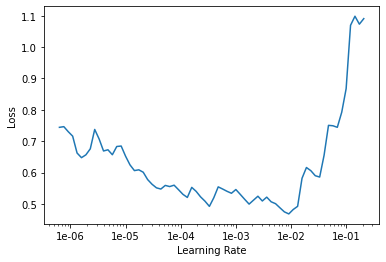

In [55]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.635228,0.381105,0.816327,0.875000,0.666667,0.945578,00:15
1,0.536443,0.349897,0.877551,0.894737,0.809524,0.945578,00:15
2,0.512136,0.344853,0.857143,0.850000,0.809524,0.942177,00:15
3,0.416277,0.350728,0.857143,0.850000,0.809524,0.945578,00:14
4,0.382743,0.340198,0.857143,0.850000,0.809524,0.942177,00:15


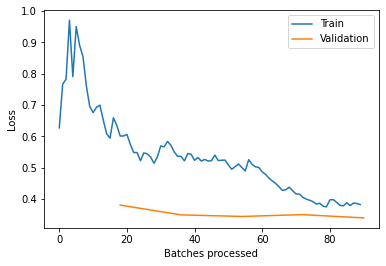

In [56]:
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-4))
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2')

In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


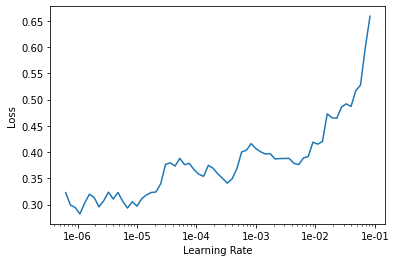

In [63]:
learn.recorder.plot()

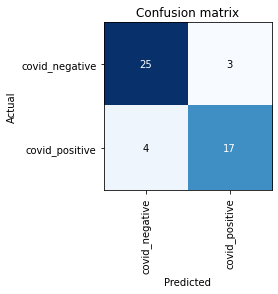

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

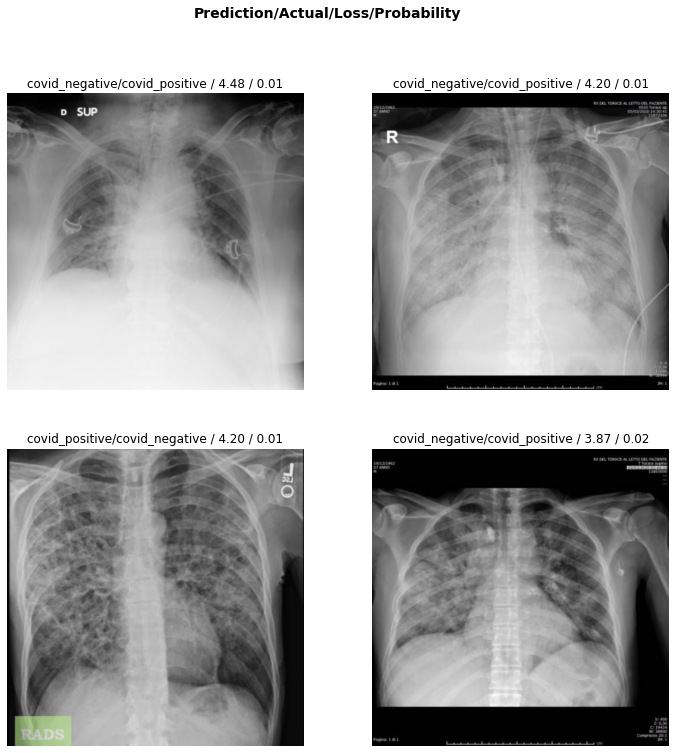

In [0]:
interp.plot_top_losses(4)

In [0]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)